In [1]:
import torch
import numpy as np
import cv2
import os 
import pandas as pd
import albumentations as A
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from albumentations.pytorch.functional import img_to_tensor
from tensorboardX import SummaryWriter
from tqdm.notebook import tqdm
from torch.utils.data.dataloader import default_collate

In [2]:
from helpers5classes.config import load_config
from helpers5classes.utils import create_optimizer, AverageMeter
from helpers5classes.losses import miou_round, val_miou_round
from helpers5classes import losses
conf = load_config('helpers5classes/effb7_conf.json') 

In [3]:
PTH = 'Oil Spill Detection Dataset/'

In [4]:
train = os.path.join(PTH, 'train/images')
train_mask = os.path.join(PTH, 'train/labels')

valid = os.path.join(PTH, 'test/images')
valid_mask = os.path.join(PTH, 'test/labels')

# Create transforms

In [5]:
def create_train_transforms():
    #(650,1250) > 512x512 > 512x512 > (650x1250) > 
    
#     return A.Compose([
#         A.RandomCrop(640, 640, p=1.0),
#         #A.ShiftScaleRotate(),
#         A.HorizontalFlip()
#     ])
    return A.Compose([
            A.RandomCrop(640, 640, p=1.0),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=1.0),
            A.OneOf([
                A.MotionBlur(p=.2),
                A.MedianBlur(blur_limit=3, p=.1),
                A.Blur(blur_limit=3, p=.1),
            ], p=1.0),
            A.Transpose(p=1.0),
            A.RandomRotate90(p=1.0),
            A.HorizontalFlip(p=1.0),
        ])

def create_val_transforms():
    return A.Compose([
        A.Crop(0,0,640,640, p=1.0)
    ])

# Convert RGB mask to 1D mask

In [6]:
def rgb_to_label(rgb_mask):
    color_to_label = {
        (0,0,0): 0,
        (0,255,255): 1,
        (255,0,0): 2,
        (153, 76,0): 3,
        (0,153,0): 4
    }
    height, width, _ = rgb_mask.shape
    label_mask = np.zeros((height, width), dtype = np.uint8)
    
    for color, label in color_to_label.items():
        indices = np.where(np.all(rgb_mask==color, axis=-1))
        #print(indices)
        label_mask[indices] = label
    return label_mask

In [7]:
rgb_mask = cv2.imread('Oil Spill Detection Dataset/train/labels/42_916,10_638_3.png')

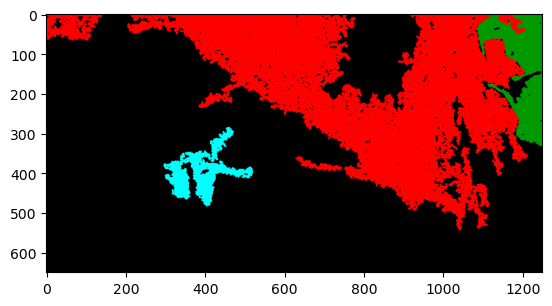

In [11]:
plt.imshow(cv2.cvtColor(rgb_mask, cv2.COLOR_BGR2RGB))

In [12]:
label_mask = rgb_to_label(cv2.cvtColor(rgb_mask, cv2.COLOR_BGR2RGB))

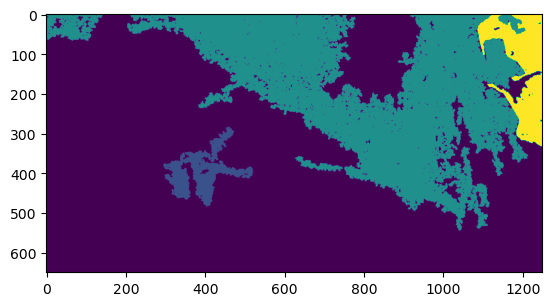

In [13]:
plt.imshow(label_mask)

In [9]:
np.unique(label_mask)

array([0, 4], dtype=uint8)

# Create CSV with common file names

In [10]:
def common_ims(img_pth, mask_pth, mode):
    img_ids = os.listdir(img_pth)
    mask_ids = os.listdir(mask_pth)
    mask_ids = [s.replace('png', 'jpg') for s in mask_ids]
    
    img_df = pd.DataFrame({'filename': img_ids})
    mask_df = pd.DataFrame({'filename': mask_ids})

    merged_df = pd.merge(img_df, mask_df, on='filename')
    merged_df.to_csv(f'{mode}.csv', index=False)

In [11]:
common_ims(train, train_mask, 'train')
common_ims(valid, valid_mask, 'valid')

In [12]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('valid.csv') #test.csv

In [13]:
len(os.listdir(train)), len(os.listdir(train_mask))

(1002, 1002)

# Dataset

In [14]:
class OilDataset(Dataset):
    def __init__(self, df, mode='train', classes=None, augmentations = None, normalize = None):
        self.df = df['filename']
        self.mode = mode
        self.classes = classes
        self.augmentations = augmentations
        self.normalize = normalize
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(f'Oil Spill Detection Dataset/{self.mode}/images/', self.df[idx]))
        mask = cv2.imread(os.path.join(f'Oil Spill Detection Dataset/{self.mode}/labels/', self.df[idx].replace('jpg', 'png')))
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = rgb_to_label(mask)
        if self.augmentations:
            sample = self.augmentations(image=image, mask=mask)
            #image, mask = sample['image'], sample['mask']
        
        mask = np.zeros((self.classes, *sample["mask"].shape[:2]))
        for i in range(self.classes):
            mask[i, sample["mask"] == i] = 1
        
        sample['img_name'] = os.path.join(f'Oil Spill Detection Dataset/{self.mode}/images/', self.df[idx])
        sample['mask_orig'] = sample['mask']
        sample['mask'] = torch.from_numpy(np.ascontiguousarray(mask)).float()
        sample['image'] = img_to_tensor(np.ascontiguousarray(sample['image']), self.normalize)
        return sample
        
        

In [15]:
dataset = OilDataset(train_df, mode='train', classes = 5, augmentations=create_train_transforms(), normalize = conf['input']['normalize'])

In [16]:
dataset[0]['image'].shape, dataset[0]['img_name'], dataset[0]['mask'].shape, dataset[0]['mask_orig'].shape

(torch.Size([3, 640, 640]),
 'Oil Spill Detection Dataset/train/images/27_884,-17_39_2.jpg',
 torch.Size([5, 640, 640]),
 (640, 640))

# Config

# Train

In [17]:
def train_epoch(current_epoch, loss_functions, model, optimizer, scheduler, train_data_loader, 
                summary_writer, conf):
    losses = AverageMeter()
    mious = AverageMeter()
    iterator = tqdm(train_data_loader)
    model.train()
    if conf["optimizer"]["schedule"]["mode"] == "epoch":
        scheduler.step(current_epoch)
    for i, sample in enumerate(iterator):
        imgs = sample["image"].cuda()
        masks = sample["mask"].cuda().float()
#         imgs = sample[0]
#         masks = sample[1].float()
        masks_orig = sample["mask_orig"].cuda().float()
        out_mask = model(imgs)
        with torch.no_grad():
            pred = torch.softmax(out_mask, dim=1)
            argmax = torch.argmax(pred, dim=1)
            ious = miou_round(argmax, masks_orig).item()

        mious.update(ious, imgs.size(0))

        mask_loss = loss_functions["mask_loss"](out_mask, masks.contiguous())
        loss = mask_loss
        losses.update(loss.item(), imgs.size(0))
        iterator.set_description(
            "epoch: {}; lr {:.7f}; Loss ({loss.avg:.4f}); miou ({miou.avg:.4f}); ".format(
                current_epoch, scheduler.get_lr()[-1], loss=losses, miou=mious))
        optimizer.zero_grad()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        #torch.cuda.synchronize()

        if conf["optimizer"]["schedule"]["mode"] in ("step", "poly"):
            scheduler.step(i + current_epoch * len(train_data_loader))
   
    for idx, param_group in enumerate(optimizer.param_groups):
        lr = param_group['lr']
        summary_writer.add_scalar('group{}/lr'.format(idx), float(lr), global_step=current_epoch)
    summary_writer.add_scalar('train/loss', float(losses.avg), global_step=current_epoch)

In [18]:
def validate(net, data_loader, predictions_dir):
    os.makedirs(predictions_dir, exist_ok=True)
    preds_dir = predictions_dir + "/predictions"
    os.makedirs(preds_dir, exist_ok=True)
    mious = []
    oil_class_iou = []
    with torch.no_grad():
        for sample in tqdm(data_loader):
            imgs = sample["image"].cuda().float()
            mask_orig = sample["mask_orig"].cuda().float()
#             imgs = sample[0]
#             mask_orig = sample[1].float()

            output = net(imgs)
            pred = torch.softmax(output, dim=1)
            argmax = torch.argmax(pred, dim=1)

            for i in range(output.shape[0]):
                d, ious = val_miou_round(argmax, mask_orig)
                
                mious.append(d.item())
                oil_class_iou.append(ious[1].item())
                cv2.imwrite(os.path.join(preds_dir, "test_" + sample['img_name'][i].split('/')[-1].replace('.png', '') + "_prediction.png"),
                            argmax[i].cpu().numpy().astype(np.uint8) * 64) #cpu()
 
                cv2.imwrite(os.path.join(preds_dir, "test_" + sample['img_name'][i].split('/')[-1].replace('.png', '') + "_mask_orig.png"),
                            mask_orig[i].cpu().numpy().astype(np.uint8) * 64) #cpu()
    print(np.mean(oil_class_iou))
    return np.mean(mious)
def evaluate_val(output_dir, data_val, miou_best, model, snapshot_name, current_epoch, optimizer, summary_writer,
                 predictions_dir):
    print("Test phase")
    model = model.eval()
    miou = validate(model, data_loader=data_val, predictions_dir=predictions_dir)
    summary_writer.add_scalar('val/miou', float(miou), global_step=current_epoch)
    if miou > miou_best:
        if output_dir is not None:
            torch.save({
                'epoch': current_epoch + 1,
                'state_dict': model.state_dict(),
                'miou_best': miou,

            }, output_dir + "/" + snapshot_name + "_best_miou.pt")
        miou_best = miou
    torch.save({
        'epoch': current_epoch + 1,
        'state_dict': model.state_dict(),
        'miou_best': miou_best,
    }, output_dir + snapshot_name + "_last.pt")
    print("miou: {}, miou_best: {}".format(miou, miou_best))
    return miou_best

In [19]:
import segmentation_models_pytorch as smp
model = smp.Unet(encoder_name='efficientnet-b7', classes=5) #'resnet34'
model = model.cuda()

In [20]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device, non_blocking=True)

In [21]:
mask_loss_function = losses.__dict__[conf["mask_loss"]["type"]](**conf["mask_loss"]["params"]).cuda()
loss_functions = {"mask_loss": mask_loss_function}
optimizer, scheduler = create_optimizer(conf['optimizer'], model)

miou_best = 0
start_epoch = 0
batch_size = conf['optimizer']['batch_size']
#print(train_lst)
data_train = OilDataset(train_df,
                        mode='train', 
                        classes = 5, 
                        augmentations=create_train_transforms(), 
                        normalize = conf['input']['normalize'])
data_val = OilDataset(test_df,
                        mode='test', 
                        classes = 5, 
                        augmentations=create_val_transforms(), 
                        normalize = conf['input']['normalize'])
train_sampler = None

In [22]:
train_data_loader = DataLoader(data_train, batch_size=batch_size,
                                   shuffle=train_sampler is None, sampler=train_sampler, pin_memory=False,
                                   drop_last=True) #num_workers=16,

#print(data_train.__getitem__(1)['image'].shape)
#print(data_train.__getitem__(1)['mask'].shape)
val_batch_size = 1 
val_data_loader = DataLoader(data_val, batch_size=val_batch_size, shuffle=False,
                             pin_memory=False) #num_workers=16

In [23]:
#!mkdir predictions

In [24]:
output_dir = 'outputs'
predictions_path = 'predictions'

In [25]:
logdir = 'logs'
summary_writer = SummaryWriter(logdir + '/' + 'segment_' + conf['encoder'])

In [26]:
start_epoch = 0
current_epoch=0

In [27]:
snapshot_name = "{}{}_{}".format('segment_', conf['network'], conf['encoder'])

In [29]:
# train_data_loader = DataLoader([(i['image'].to(device), i['mask']) for i in train_data_loader], batch_size=batch_size,
#                                    shuffle=train_sampler is None, sampler=train_sampler, pin_memory=False,
#                                    drop_last=True)

# val_data_loader = DataLoader([(i['image'].to(device), i['mask']) for i in val_data_loader], batch_size=val_batch_size, shuffle=False,
#                              pin_memory=False)

In [30]:
for epoch in range(start_epoch, conf['optimizer']['schedule']['epochs']):
        if train_sampler:
            train_sampler.set_epoch(epoch)

        model_encoder_stages = model.encoder
        model_encoder_stages.train()
        for p in model_encoder_stages.parameters():
            p.requires_grad = True
        
        train_epoch(current_epoch, loss_functions, model, 
                    optimizer, scheduler, train_data_loader, summary_writer, conf)

        model = model.eval()
        
        torch.save({
            'epoch': current_epoch + 1,
            'state_dict': model.state_dict(),
            'miou_best': miou_best,
        }, output_dir + '/' + snapshot_name + "_last")
        preds_dir = os.path.join(predictions_path, snapshot_name)
        miou_best = evaluate_val(output_dir, val_data_loader, miou_best, model,
                                 snapshot_name=snapshot_name,
                                 current_epoch=current_epoch,
                                 optimizer=optimizer, summary_writer=summary_writer,
                                 predictions_dir=preds_dir)
        current_epoch += 1


  0%|          | 0/250 [00:00<?, ?it/s]

C:\Users\spark lab\anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
C:\Users\spark lab\anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable t

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.5013365473959016
miou: 0.5871133345094595, miou_best: 0.5871133345094595


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.5955272277104484
miou: 0.6742797361178832, miou_best: 0.6742797361178832


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6493507089741043
miou: 0.718275170434605, miou_best: 0.718275170434605


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6388623984537801
miou: 0.6975652969696305, miou_best: 0.718275170434605


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6093032594911975
miou: 0.6741168607365001, miou_best: 0.718275170434605


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6539848589718443
miou: 0.7183904111385345, miou_best: 0.7183904111385345


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6561470769354331
miou: 0.6640637302940542, miou_best: 0.7183904111385345


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6953194277368605
miou: 0.7188105443661863, miou_best: 0.7188105443661863


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6412448370296036
miou: 0.675464289161292, miou_best: 0.7188105443661863


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6887111021144355
miou: 0.6934598724950444, miou_best: 0.7188105443661863


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6733678096473528
miou: 0.692540600083091, miou_best: 0.7188105443661863


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.659114508779745
miou: 0.7084137561646375, miou_best: 0.7188105443661863


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6663517951609298
miou: 0.7062390392476862, miou_best: 0.7188105443661863


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7268704564900735
miou: 0.7356211578304117, miou_best: 0.7356211578304117


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7351673120815929
miou: 0.7332846748557957, miou_best: 0.7356211578304117


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7095798891211385
miou: 0.7311431323940104, miou_best: 0.7356211578304117


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7136754969691347
miou: 0.7360628794540058, miou_best: 0.7360628794540058


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.6789499183265355
miou: 0.7275843373753808, miou_best: 0.7360628794540058


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7058529131371801
miou: 0.7506698176264763, miou_best: 0.7506698176264763


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7197408010601031
miou: 0.7415782616897063, miou_best: 0.7506698176264763


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7306604670933462
miou: 0.7346039614894173, miou_best: 0.7506698176264763


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7281824615383269
miou: 0.7828409482132305, miou_best: 0.7828409482132305


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7072730114957185
miou: 0.7505358664826913, miou_best: 0.7828409482132305


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7314748531456458
miou: 0.717126128077507, miou_best: 0.7828409482132305


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7237492170019462
miou: 0.7702315461906519, miou_best: 0.7828409482132305


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7227205089195058
miou: 0.7307981130751696, miou_best: 0.7828409482132305


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7422482421843328
miou: 0.7379767753861167, miou_best: 0.7828409482132305


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7456059665761554
miou: 0.7441047871654684, miou_best: 0.7828409482132305


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7257853525804476
miou: 0.7467645085670731, miou_best: 0.7828409482132305


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7373209724003909
miou: 0.7442703917622566, miou_best: 0.7828409482132305


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7403914333628646
miou: 0.7614618717269463, miou_best: 0.7828409482132305


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.710357645902852
miou: 0.7545320494608445, miou_best: 0.7828409482132305


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7310807331364239
miou: 0.749342521483248, miou_best: 0.7828409482132305


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7344672084040572
miou: 0.7714968391440131, miou_best: 0.7828409482132305


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7262644928716381
miou: 0.749912158738483, miou_best: 0.7828409482132305


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7303660299881923
miou: 0.7843831726095893, miou_best: 0.7843831726095893


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.730360200759925
miou: 0.7826341466470198, miou_best: 0.7843831726095893


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7169225920606721
miou: 0.7764051096005873, miou_best: 0.7843831726095893


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7328441421312385
miou: 0.777672726186839, miou_best: 0.7843831726095893


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.735504187771949
miou: 0.7888059350577268, miou_best: 0.7888059350577268


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.72911082220408
miou: 0.7877753233367747, miou_best: 0.7888059350577268


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7424990142831573
miou: 0.7983115464448929, miou_best: 0.7983115464448929


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7552869666640017
miou: 0.8004663516174663, miou_best: 0.8004663516174663


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7367796207087391
miou: 0.7932121450250799, miou_best: 0.8004663516174663


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7404855136343537
miou: 0.8191068096594377, miou_best: 0.8191068096594377


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.729864026945534
miou: 0.794527328285304, miou_best: 0.8191068096594377


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7257597653854377
miou: 0.8162013874812559, miou_best: 0.8191068096594377


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7257294303442505
miou: 0.8259703752669421, miou_best: 0.8259703752669421


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7240842532043777
miou: 0.8116725450212305, miou_best: 0.8259703752669421


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7480756219163134
miou: 0.8258989959955215, miou_best: 0.8259703752669421


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7380504079382617
miou: 0.828168966553428, miou_best: 0.828168966553428


  0%|          | 0/250 [00:00<?, ?it/s]

Test phase


  0%|          | 0/110 [00:00<?, ?it/s]

0.7335119937345221
miou: 0.8186673820018768, miou_best: 0.828168966553428


  0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: 

# 1d to RGB

In [ ]:
import numpy as np
import cv2

def convert_mask(mask):
   
    color_mappings = {
        0: (0, 0, 0),
        1: (0, 255, 255),
        2: (255, 0, 0),
        3: (153, 76, 0),
        4: (0, 153, 0)
    }

   
    height, width= mask.shape
    rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)

   
    for class_idx, color in color_mappings.items():
        class_mask = (mask == class_idx)
        rgb_mask[class_mask] = color

    
    return rgb_mask


In [ ]:
img1 = cv2.imread('predictions/segment_resnet34_resnet34/predictions/test_42_308,18_108_1.jpg_mask_orig.png')
img2 = cv2.imread('predictions/segment_resnet34_resnet34/predictions/test_42_308,18_108_1.jpg_prediction.png')

In [ ]:
img1 = img1/64
img2 = img2/64

In [ ]:
plt.imshow(img1)

In [ ]:
plt.imshow(img2)

In [ ]:
plt.imshow(convert_mask(img1[:,:,1]))

In [ ]:
plt.imshow(convert_mask(img2[:,:,1]))

In [ ]:
img[:,:,1].shape

In [10]:
# 650x1250 > 